<a href="https://colab.research.google.com/github/choderalab/pinot/blob/examples/examples/supervised_learning_with_deep_graph_kernel_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Learning with Deep Graph Kernel Learning
===================================================

Yuanqing Wang (wangyq@wangyq.net)

In this example we show the simplest example of `pinot`. 

# Download and install

In [1]:
! git clone https://github.com/choderalab/pinot.git --depth=1

Cloning into 'pinot'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 255 (delta 21), reused 169 (delta 9), pack-reused 0
Receiving objects: 100% (255/255), 26.72 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [3]:
! cd /content/pinot && pip install -q -r requirements.txt && pip install -q .

In [9]:
! wget -q -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! time bash ./Miniconda3-latest-Linux-x86_64.sh -q -b -f -p /usr/local
! time conda install -q -y -c conda-forge rdkit


PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py37_0
    - cryptography==2.9.2=py37h1ba5d50_0
    - idna==2.9=py_1
    - ld_impl_linux-64==2.33.1=h53a641e_7
    - libedit==3.1.20181209=hc058e9b_0
    - libffi==3.3=he6710b0_1
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - ncurses==6.2=he6710b0_1
    - openssl==1.1.1g=h7b6447c_0
    - pip==20.0.2=py37_3
    - pycosat==0.6.3=py37h7b6447c_0
    - pycparser==2.20=py_0
    - pyopenssl==19.1.0=py37_0
    - pysocks==1.7.1=py37_0
    - python==3.7.7=hcff3b4d_5
    - readline==8.0=h7b6447c_0
    - requests==2.23.0=py37_0
    - ruamel_yaml==0.15.87=py37h

In [10]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [11]:
import pinot

# Overview

In `pinot`, the forward pass that takes a _molecular graph_ and outputs a _predictive distribution_ is separated into two parts:
- representation
- regression

In **representation**, $\mathcal{G} \rightarrow h$,  we use graph nets to conduct message-passing steps on the nodes (atoms) and edges (bonds) of the molecular graph, and form a latent representation for each node, and by summing them up, for each graph. This is handled in `pinot.representation`.

In **regression**, $h \rightarrow y$, we transform the latent encoding into a predictive distribution. Such distribution could be either parametrized by neural networks `pinot.regressors.NeuralNetworkRegressor`, or infered by Gaussian process regression (`pinot.regressors.ExactGaussianProcessRegressor`). Alternatively, you can construct your own `Regressor` by [subclassing](https://github.com/choderalab/pinot/blob/master/pinot/regressors/base_regressor.py), as long as they take latent embedding $h \in \mathbb{R}^{(N \times D)}$ where $N$ is the batch size and $D$ is the hidden dimension, and outputs a distribution conditioned on new input graphs.

# Get dataset

Here we use the so-called 'MNIST of molecular machine learning'---[ESOL dataset.](https://pubs.acs.org/doi/10.1021/ci034243x) Note that dataset is already shuffled by default.

In [23]:
ds = pinot.data.esol()[:40] # we only grab a few to make a point 

We batch the dataset into size of 8 and split the dataset into training and test (80:20).

In [24]:
ds = pinot.data.utils.batch(ds, 8)
ds_tr, ds_te = pinot.data.utils.split(ds, [4, 1])

# Define representation architecture

Let's use the most classic [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) as graph net layer, and construct a representation model with three layers, each 32 units, and connected by `tanh`.

In [14]:
layer = pinot.representation.dgl_legacy.gn(model_name='GraphConv')

In [15]:
representation = pinot.representation.Sequential(
    layer=layer,
    config=[32, 'tanh', 32, 'tanh', 32, 'tanh']
)

# Define Exact GP as output regressor

In [16]:
output_regressor = pinot.regressors.ExactGaussianProcessRegressor

# Define a complete network

In [17]:
net = pinot.Net(
    representation=representation,
    output_regressor=output_regressor
)

Note that now this object contains both stage of the forward pass and is differentiate end-to-end. As a result, the `.parameters()` call would return all of the associated parameters. We can thus construct our optimizer as such:

In [25]:
import torch
optimizer = torch.optim.Adam(
    net.parameters(),
    1e-3
)

You also have the option to switch `torch`-generic optimizers to variational inference methods, namely `pinot.BBB` or Langevin integrators `pinot.AdLaLa`. We will cover these topics in later tutorials.

# Define training and testing experiment.

We define a `TrainAndTest` experiment here to train and evaluate altogether.

In [26]:
experiment = pinot.TrainAndTest(
    net=net,
    data_tr=ds_tr,
    data_te=ds_te,
    optimizer=optimizer,
    n_epochs=10,
    metrics=[pinot.r2, pinot.rmse, pinot.avg_nll], # reporting metrics
)

In [28]:
# run it!
results = experiment.run()

# Analyze the results

In [30]:
print(pinot.app.report.markdown(results))

|          |     r2 |   rmse |   avg_nll |
|:---------|-------:|-------:|----------:|
| test     | 0.8101 | 0.9825 |    1.3403 |
| training | 0.6612 | 1.0874 |    1.1846 |


Text(0, 0.5, 'RMSE (mol/L)')

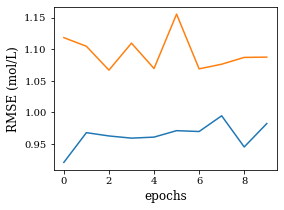

In [35]:
from matplotlib import pyplot as plt

plt.rc('font', family='serif', size=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.figure(figsize=(4, 3))

plt.plot(pinot.app.report.curve(results)[('rmse', 'test')], label='Test')
plt.plot(pinot.app.report.curve(results)[('rmse', 'training')], label='Training')

plt.xlabel('epochs')
plt.ylabel('RMSE (mol/L)')

